### Ресерч оптимизации систем
Предмет исследования - поиск алгоритма по нахождению параметров, приводящим к корректной оптимизации. 
Алгоритм должен:
* найти широкий диапазон параметров, которые позволят системе показать хорошую результативность. 
* исключить наборы параметров, показывающих исключительную результативность системы, если близкие параметры показывают значительно худший результат. 

In [1]:
"""Установка диапазонов для параметров""" 
import numpy as np

n1_set = np.arange(1, 8, 1)
k_set = np.arange(1.0, 2.7, 0.1)

In [2]:
# получение candels
from datetime import datetime
from app.clients.tinkoff import TIClient
from app.settings import TINKOFF_SANDBOX_TOKEN

TICKER = "SPCE"
_from=datetime(year=2020, month=5, day=10)
_to=datetime(year=2021, month=5, day=10)

client = TIClient(TINKOFF_SANDBOX_TOKEN, use_sandbox=True)
candles = client.get_candles_by_ticker(TICKER, _from, _to)

In [3]:
"""Получение пассивной доходности (референс)
Далее эту доходность будем вычитать из результата стратегии, чтобы получить эффект стратегии
""" 
from sim import Baffett
from sim.models import DealsView

ref_trader = Baffett()
passive_deals = ref_trader.create_deals(candles)
ref_result = DealsView(passive_deals, candles[0].close).percentage_result
print(f"ref_result: {ref_result}%")

ref_result: 19.06%


In [4]:
"""Генерация сделок для стратегии WideRange для каждого из набора параметров
Вычисление результата и формирования матрицы результатов result_matrix
"""
from bots.wide_ranging_day_bot.models import WideRangeParams
from sim import OnePaperHistoryWideRangeTrader

result_matrix = np.empty(shape=(len(n1_set), len(k_set)))
for n1_index, n1 in enumerate(n1_set):
    for k_index, k in enumerate(k_set):
        params = WideRangeParams(n1=int(n1), k=float(k))
        trader = OnePaperHistoryWideRangeTrader(params, is_short_on=True)
        deals = trader.create_deals(candles)
        if deals:
            trader_result = DealsView(deals, candles[0].close).percentage_result
            effect_result = trader_result - ref_result
            result_matrix[n1_index, k_index] = effect_result
        else:
            result_matrix[n1_index, k_index] = None
print(result_matrix)

[[103.59 112.94 120.83 266.61 266.61 328.97 289.74 267.58 267.58 238.07
  238.07 238.07 238.07 238.07 221.44 221.44 139.77]
 [202.74 202.74 210.63 274.75 274.75 328.97 289.74 267.58 267.58 202.01
  202.01 202.01 202.01 202.01 185.37 185.37 103.71]
 [202.74 202.74 210.63 274.75 274.75 328.97 253.62 231.52 231.52 202.01
  202.01 202.01 202.01 202.01 185.37 185.37 103.71]
 [202.74 202.74 210.63 274.75 274.75 328.97 253.62 231.52 231.52 202.01
  202.01 202.01 202.01 202.01 185.37 185.37 103.71]
 [202.74 202.74 210.63 274.75 274.75 328.97 253.62 231.52 231.52 202.01
  202.01 202.01 202.01 202.01 185.37 185.37 103.71]
 [202.74 202.74 210.63 274.75 274.75 328.97 253.62 231.52 231.52 202.01
  202.01 202.01 202.01 202.01 185.37 185.37 103.71]
 [202.74 202.74 210.63 274.75 274.75 328.97 253.62 231.52 231.52 202.01
  202.01 202.01 202.01 202.01 185.37 185.37 103.71]]


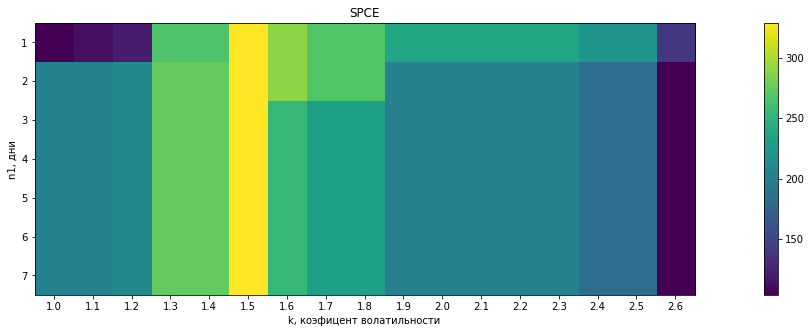

In [5]:
"""Визуализация результатов"""
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

cax = ax.imshow(result_matrix, interpolation='none')

ax.set_title(f"{TICKER}")
yaxis = np.arange(len(n1_set))
xaxis = np.arange(len(k_set))
ax.set_xticks(xaxis)
ax.set_yticks(yaxis)
ax.set_xticklabels(np.around(k_set, 2))
ax.set_yticklabels(n1_set)
plt.ylabel(f'n1, дни')
plt.xlabel(f'k, коэфицент волатильности')
fig.colorbar(cax)
fig.set_size_inches(25, 5)

plt.show()